<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Regression Modelling
---

### Regression Guide:

- [Outline](#outline)
- [Baseline Model](#baseline)
- [Pre-Processing Data](#preprocess)
- [Linear Regression](#linear) 
    - [Multivariate](#simple)
    - [Lasso](#lasso)
    - [Ridge](#ridge)
    - [ElasticNet](#elastic)
    - [Comparison](#comparison)
- [Decision Tree Regressor](#tree)
- [Random Forest Regressor](#forest)
- [KNeighbour Regressor](#knn)
- [Bagging Regressor](#bag)
- [Bagging + AdaBoost](#ada)

In [1]:
import pandas as pd
import numpy as np
import re, time
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN,KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model, metrics
from nltk.corpus import stopwords
import scikitplot as skplt
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm, linear_model

from joblib import dump, load
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'retina'
# pd.set_option('display.max_rows', 1000)

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
art= pd.read_csv('./art_data.csv')

In [3]:
art.drop(columns='Unnamed: 0',inplace=True)

In [4]:
df = art.copy(deep=True)

In [5]:
df.isnull().sum()

Artist                  0
Art_period              0
Medium_Class            0
Signed                  0
Total_prints            0
Area_dimension          0
Sale_date               0
Sale_Year               0
Sale_Month              0
Sale_Day                0
Venue_city             66
Alive                   0
performance_index    3367
linear_perf_index    3367
Realized_Price          0
dtype: int64

In [6]:
df.drop(columns = 'Sale_date', inplace = True)

- Due to computation limitations and time constraints. We will only be modelling the top 100 Artists by count and include data from 2008 onwards rather than 1998:

In [7]:
df = df[df.Sale_Year>2008]

In [8]:
top100 = []
for i in df.Artist.value_counts().index.tolist()[:100]:
    top100.append(df[df.Artist == i])
    
df = pd.concat(top100) 

In [9]:
df.shape

(63226, 14)

In [10]:
df.dropna(inplace = True)

In [11]:
df.to_csv('regression_df.csv')

<a id="outline"></a>
### Regression Modelling:
---

- My target is the realized price, a continuous variable, hence this is a regression problem.
- I will be using the following regression models to predict and explain the targe:
    - Multivariate Linear Regression Model
    - Ridge Penalty Model
    - Lasso Panalty Model
    - ElasticNet Model
    - Decision Tree Regressor
    - Random Forest Regressor
    - KNeighbour Regressor
    - Bagging Regressor

<a id="baseline"></a>
#### Baseline Model R2-Score:
---
- Below is the Baseline Model's R2-Score using mean as the central tendency measure for comparison
- This will form the baseline score in which my models will need to beat:

In [12]:
baseline_pred = [df.Realized_Price.mean()]*df.shape[0]

In [13]:
y = df.Realized_Price.tolist()

In [14]:
r2_score(y, baseline_pred)
#score: 0.0, as expected since this is a regression problem.

0.0

<a id="preprocess"></a>
#### Pre-processing the dataframe for modelling:
---
- get_dummy discrete variables
- split data set to train and test set
- Standardize the data

In [12]:
df_e =df.drop(columns = 'linear_perf_index')

In [13]:
df_l = df.drop(columns = 'performance_index')

In [14]:
def std_dummied_train_test_split(df):
    
    df_dum = pd.get_dummies(df, columns =['Artist', 'Art_period', 'Medium_Class', 'Signed', 'Sale_Month', 'Sale_Day', 'Venue_city',
       'Alive'])
    
    
    df_train = df_dum[df_dum.Sale_Year <2018]
    df_test = df_dum[df_dum.Sale_Year >2017]
    
    y_train = df_train.pop('Realized_Price')
    X_train = df_train
    y_test = df_test.pop('Realized_Price')
    X_test = df_test
    
    
    scaler = StandardScaler()
    Xs_train =pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    Xs_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return Xs_train, Xs_test, y_train, y_test 
    

In [15]:
Xs_train_e, Xs_test_e, y_train_e, y_test_e = std_dummied_train_test_split(df_e)

In [16]:
Xs_train_l, Xs_test_l, y_train_l, y_test_l = std_dummied_train_test_split(df_l)

<a id="linear"></a>
#### Linear Regression Modelling and regularization methods: Lasso, Ridge and ElasticNet 
---

- Linear regression is one of the most important and widely used regression techniques. 
- It’s one of the simplest regression methods. 
- It allows easy interpretation of results.
- If 𝑅² = 1 then SSR = 0 (sum of squared residuals), hence a perfect fit 
- Ridge and Lasso regression are used to reduce model complexity and prevent over-fitting for modelling with linear regression.


<a id="basic"></a>
#### Multivariate Linear Regression:
- Multivariate linear regression is a case of linear regression with two or more independent variables.

In [20]:
linmodel = LinearRegression()
linmodel.fit(Xs_train_l, y_train_l)
print('Train score: ', linmodel.score(Xs_train_l, y_train_l))
print('Test score: ', linmodel.score(Xs_test_l, y_test_l))
print('Cross validated score: ', cross_val_score(linmodel, Xs_train_l, y_train_l, cv=5).mean())


Train score:  0.12718132131490822
Test score:  -5.5154579124451484e+22
Cross validated score:  -1.9197592697302803e+27


In [21]:
linmodel_e = LinearRegression()
linmodel_e.fit(Xs_train_e, y_train_e)
print('Train score: ', linmodel_e.score(Xs_train_e, y_train_e))
print('Test score: ', linmodel_e.score(Xs_test_e, y_test_e))
print('Cross validated score: ', cross_val_score(linmodel_e, Xs_train_e, y_train_e, cv=5).mean())

Train score:  0.12553283993859543
Test score:  -1.566500628815201e+23
Cross validated score:  -2.1980635325402744e+27


- Based on the above scores I will proceed with the exponentially weighted perfomance index rather than the linear performance index:

In [17]:
Xs_train = Xs_train_e
Xs_test = Xs_test_e
y_train = y_train_e
y_test = y_test_e

<a id="lasso"></a>
#### Lasso:
---
- Lasso regression performs L1 regularization
- It adds a penalty equal to the absolute value of the magnitude of coefficients to the cost function. 
- This type of regularization means some coefficients can become zero and eliminated from the model.
- Not only does lasso help in reducing over-fitting but it can help us in feature selection
- It is also good for models showing high levels of muticollinearity

In [23]:
lassomodel = LassoCV(n_alphas=1000, cv=5, random_state=1)
lassomodel.fit(Xs_train_l, y_train_l)
print('Train score: ', lassomodel.score(Xs_train, y_train))
print('Test score: ', lassomodel.score(Xs_test, y_test))
print('Cross validated score: ', cross_val_score(lassomodel, Xs_test, y_test, cv=5).mean())

Train score:  0.11586533978832791
Test score:  0.10865817734332661
Cross validated score:  0.04584130613806594


In [24]:
dump(lassomodel, '100lassomodel.joblib')

['100lassomodel.joblib']

<a id="ridge"></a>
#### Ridge:
---
- Ridge regression performs L2 regularization
- The cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients.
- All coefficients are shrunk by the same factor, hence none are eliminated. 
- Unlike lasso, ridge will not result in sparse models.


In [25]:
ridgemodel = RidgeCV(alphas=np.logspace(3, 4, 100), cv=5,)
ridgemodel.fit(Xs_train, y_train)
dump(ridgemodel, '100ridgemodel.joblib')

['100ridgemodel.joblib']

In [26]:
print('Optimum alpha:', ridgemodel.alpha_)
print("Train Score:", ridgemodel.score(Xs_train, y_train))
print("Test Score:", ridgemodel.score(Xs_test, y_test))
print('Cross validated score: ', cross_val_score(ridgemodel, Xs_train, y_train, cv=5).mean())

Optimum alpha: 10000.0
Train Score: 0.12541305931485847
Test Score: 0.11649605826489305
Cross validated score:  0.015369299227263822


<a id="elastic"></a>
#### Elastic Net:
---
- The elastic net linearly combines L1 and L2 penalties.

In [27]:
elasticmodel = ElasticNetCV(l1_ratio=[0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     n_alphas = 1000, cv=5, max_iter= 10000)
elasticmodel.fit(Xs_train, y_train)
dump(elasticmodel, '100elasticmodel.joblib')

['100elasticmodel.joblib']

In [28]:
print('Optimum alpha:', elasticmodel.alpha_)
print('Optimum l1 ratio:',elasticmodel.l1_ratio_)
print('Training score:', elasticmodel.score(Xs_train, y_train))
print("Test Score:", elasticmodel.score(Xs_test, y_test))
print('Cross validated score: ', cross_val_score(elasticmodel, Xs_train, y_train, cv=5).mean())

Optimum alpha: 387.02527352413335
Optimum l1 ratio: 1.0
Training score: 0.11684771556680973
Test Score: 0.10950449598920133
Cross validated score:  0.01660551231778078


#### Comparison:
---
<a id="comparison"></a>

Cross validation Score
- Linear Regression: -2.1980635325402744e+27
- Lasso: 0.04584130613806594
- Ridge: 0.015369299227263822
- ElasticNet: 0.01660551231778078

Hence, <u>Lasso</u> is the best giving a R2-score of <b> 0.10865817734332661</b>

In [51]:
lasso_coef = pd.DataFrame(lassomodel.coef_, index=Xs_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients
lasso_coef['coef_abs'] = lasso_coef.coefficients.abs()
lasso_coef.sort_values(by= 'coefficients').head(5)

,coefficients,coef_abs
Venue_city_Oslo,-1272.613260,1272.613260
Total_prints,-983.690702,983.690702
Sale_Month_7,-813.221873,813.221873
Art_period_Dada_Surrealism,-434.523449,434.523449
Artist_Joan Miró,-370.064152,370.064152


In [84]:
lasso_coef.sort_values(by= 'coefficients').tail(5)

,coefficients,coef_abs
Venue_city_New York,3298.001076,3298.001076
Medium_Class_308,3479.869066,3479.869066
Venue_city_London,3562.008497,3562.008497
Artist_Edvard Munch,4934.561515,4934.561515
performance_index,6018.007059,6018.007059


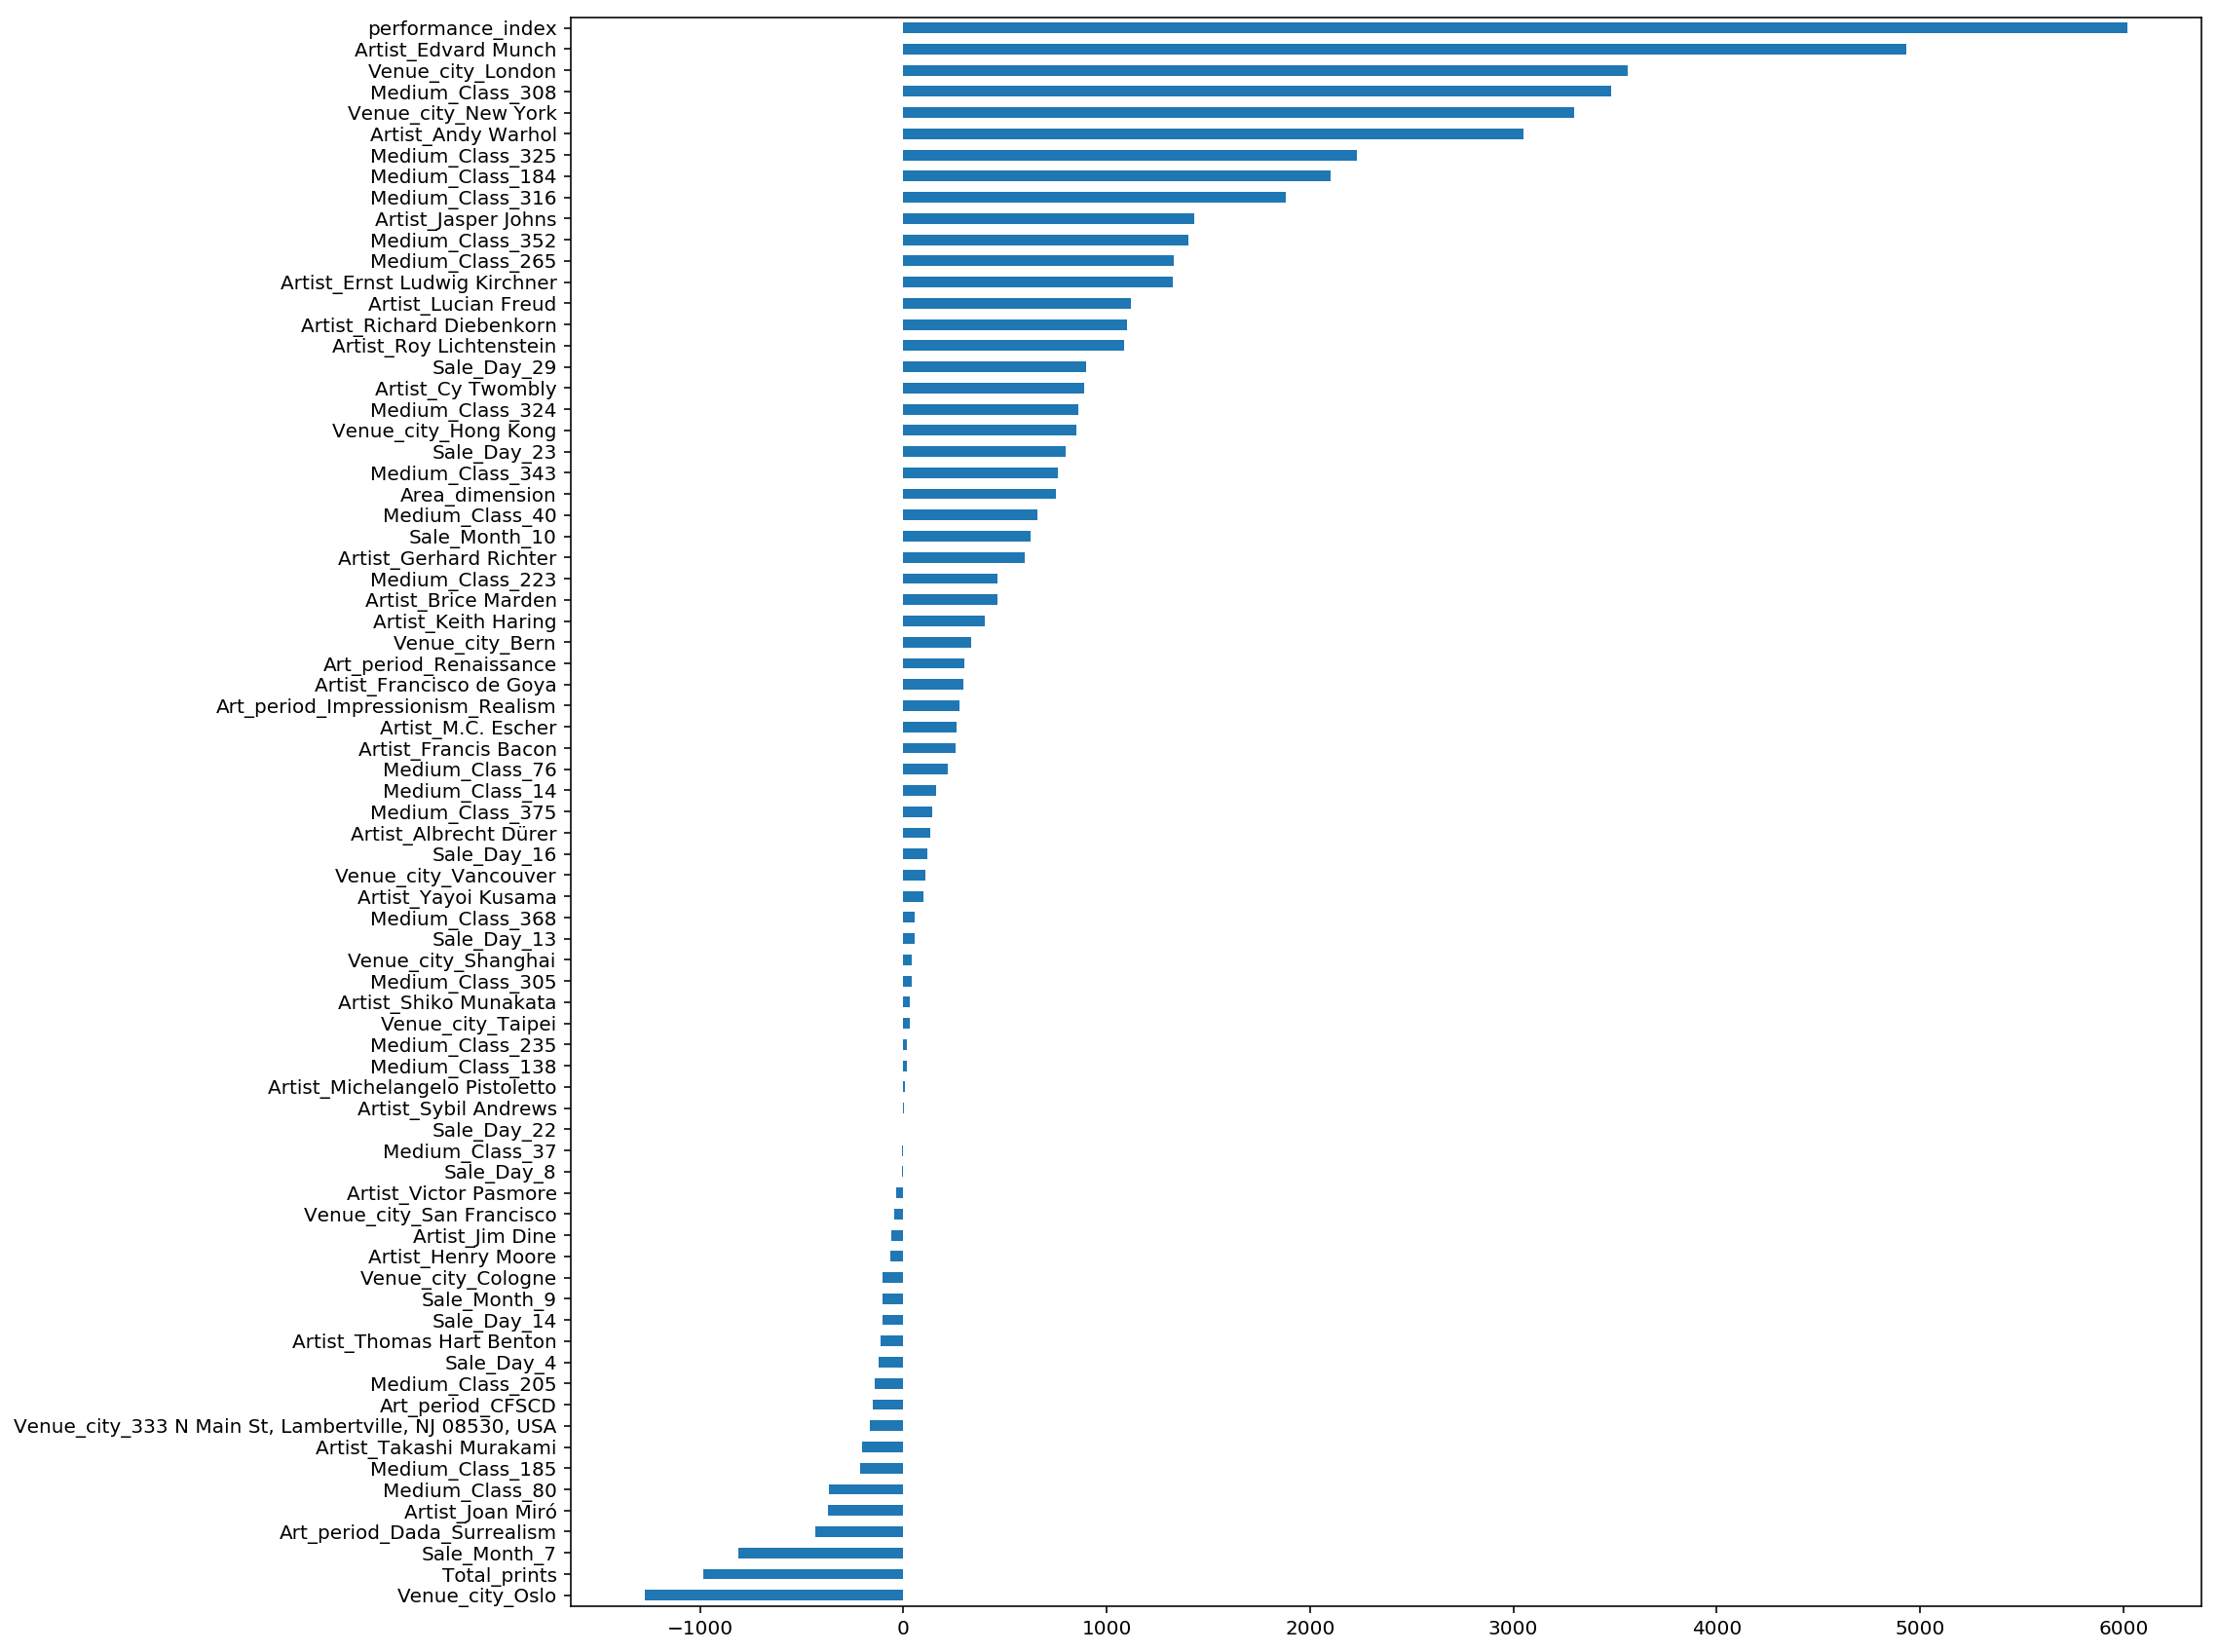

In [83]:
lasso_coef[lasso_coef['coefficients']!=0]['coefficients'].sort_values().plot(kind='barh', figsize=(15, 15)) ;

In [52]:
lasso_pred = lassomodel.predict(Xs_test)

In [54]:
lassotrain_pred = lassomodel.predict(Xs_train)

Text(0, 0.5, 'Predicted Sale Price')

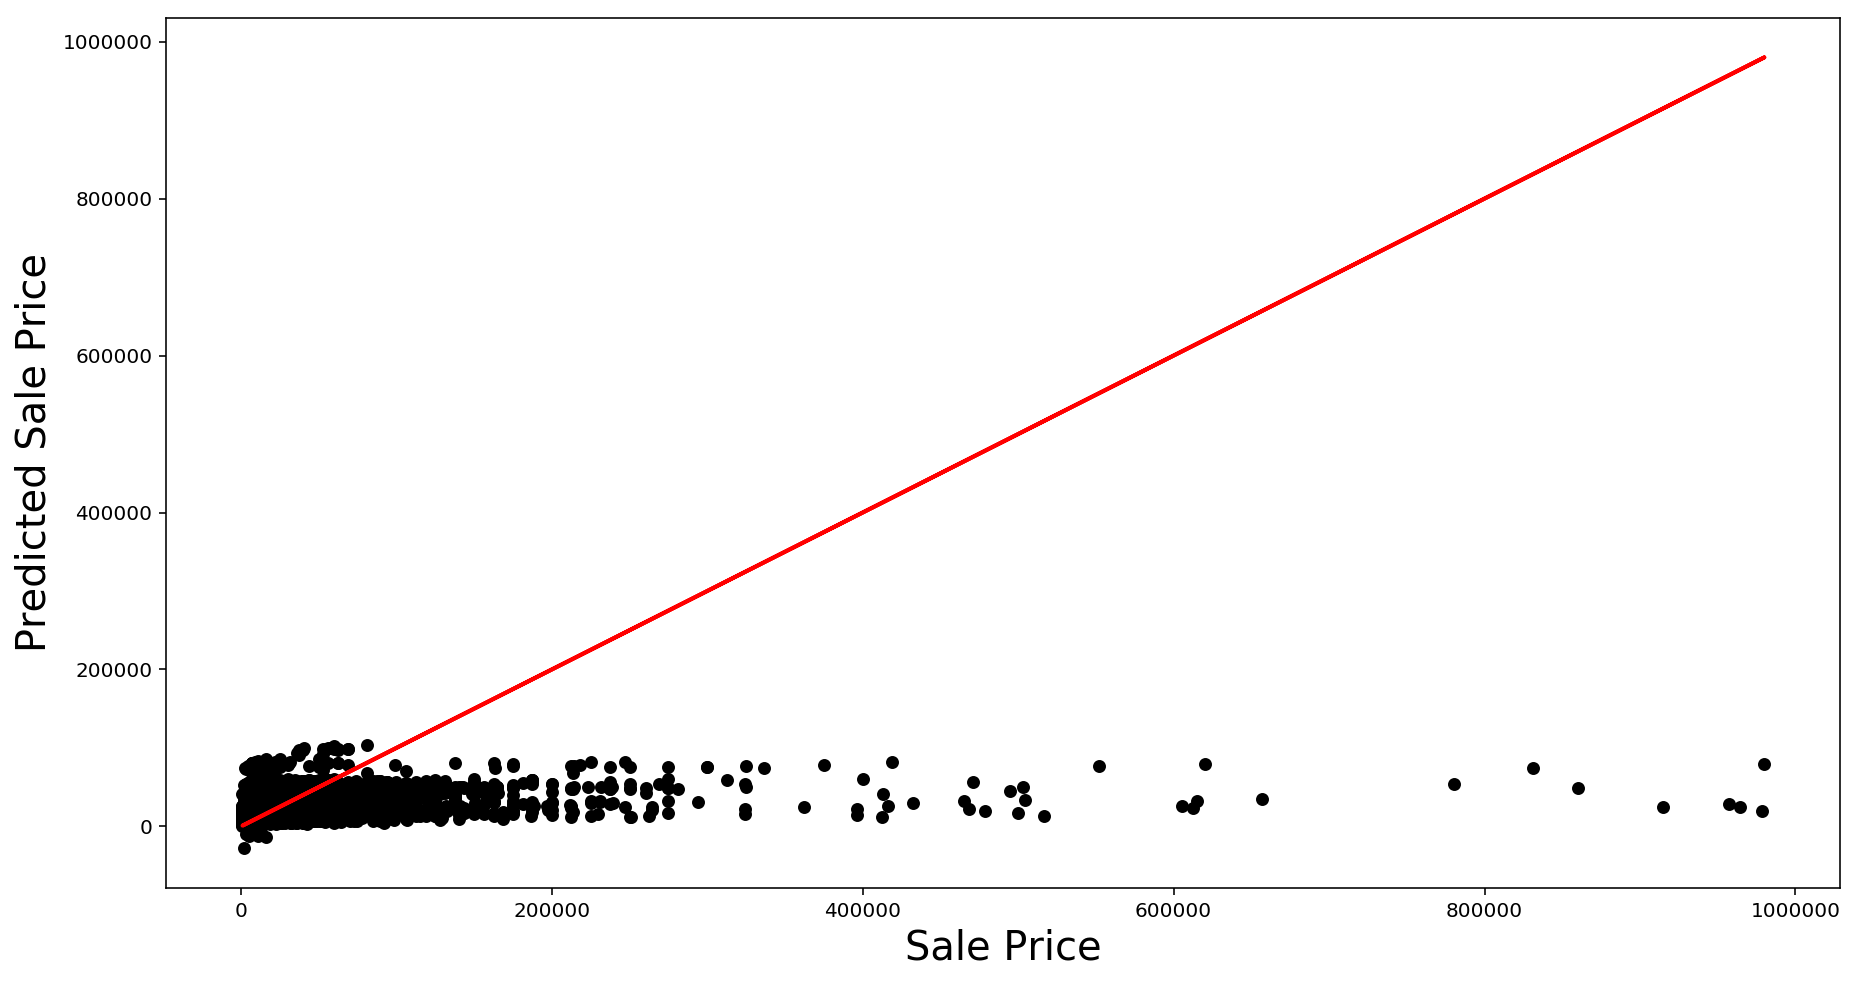

In [53]:
fig = plt.figure(figsize=(15, 8))
ax = fig.gca()

ax.scatter(x=y_test, y=lasso_pred, c='k', s=30)
ax.plot(y_test, y_test, color='r', lw=2)
ax.set_xlabel('Sale Price',fontsize=20)
ax.set_ylabel('Predicted Sale Price',fontsize=20)

In [55]:
lassores_train = y_train - lassotrain_pred
lassores_test = y_test - lasso_pred

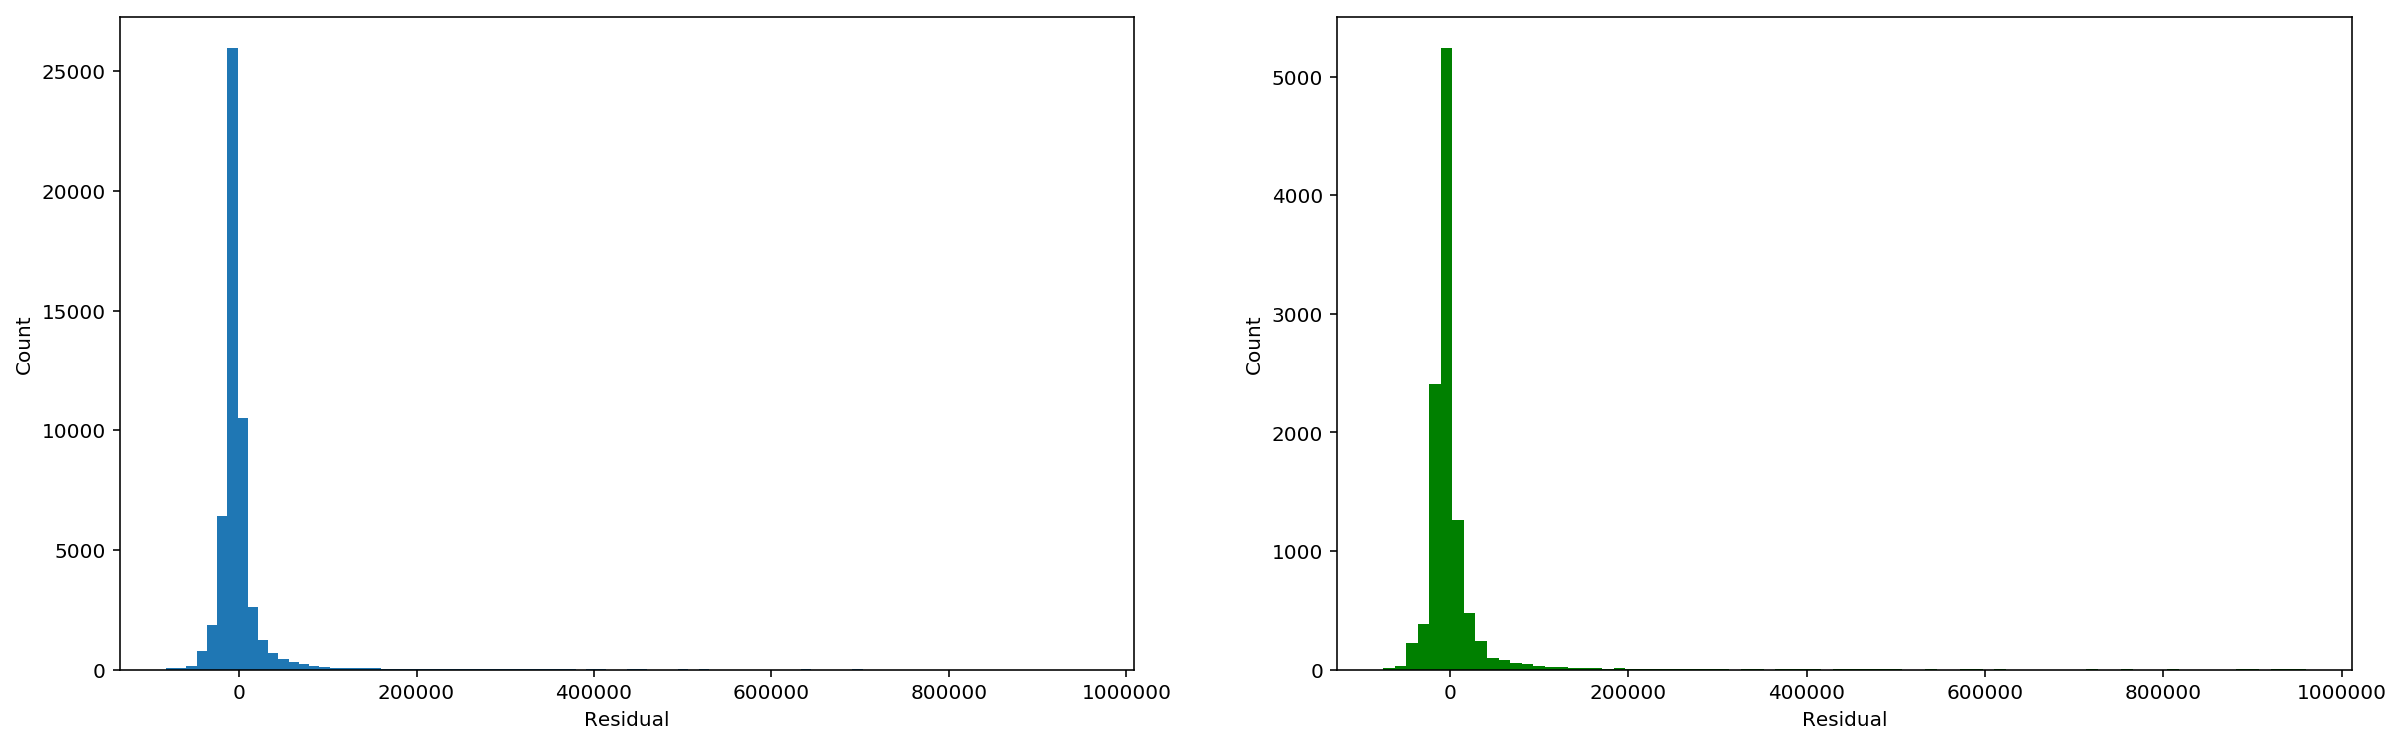

In [67]:
fig, ax = plt.subplots(1,2, figsize=(20, 6))
ax[0].hist(lassores_train, bins= 90)
ax[0].set_xlabel('Residual')
ax[0].set_ylabel('Count')

ax[1].hist(lassores_test, bins= 80, color = 'g')
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')

plt.show()

#### Decision Tree Regressor Model:
---
<a id="tree"></a>
- Decision-tree algorithm falls under the category of supervised learning algorithms.
- The decision tree regressor observes features of an object and trains a model in the structure of a tree to predict the target

In [29]:
regressor = DecisionTreeRegressor(criterion='mse',max_depth=1, random_state=1)
regressor_params = {'max_depth': range(1,15)}
regressor_gs = GridSearchCV(regressor, regressor_params, verbose=1, cv=5, n_jobs=-1)

In [30]:
regressor_gs.fit(Xs_train, y_train)
best_regressor = regressor_gs.best_estimator_
dump(best_regressor, '100best_tree.joblib')

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   30.8s finished


['100best_tree.joblib']

In [31]:
print('Best Score: ', regressor_gs.best_score_)
print('Best test score: ', best_regressor.score(Xs_test, y_test))
print('Cross validated score: ', cross_val_score(best_regressor, Xs_train, y_train, cv=5).mean())

Best params:  <bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')>
Best Score:  0.003938564405900127
Best test score:  0.0664256780541097
Cross validated score:  0.003938812731385921


In [ ]:
print('Best params: ', best_regressor.get_params())

In [32]:
feature_importances = best_regressor.feature_importances_
pd.DataFrame(list(zip(Xs_train.columns, best_regressor.feature_importances_)), columns=[
             'Feature', 'Importance']).sort_values(by='Importance', ascending=False).head()

,Feature,Importance
3,performance_index,0.421818
1,Area_dimension,0.199587
24,Artist_Edvard Munch,0.109391
211,Medium_Class_184,0.080664
290,Medium_Class_308,0.064209


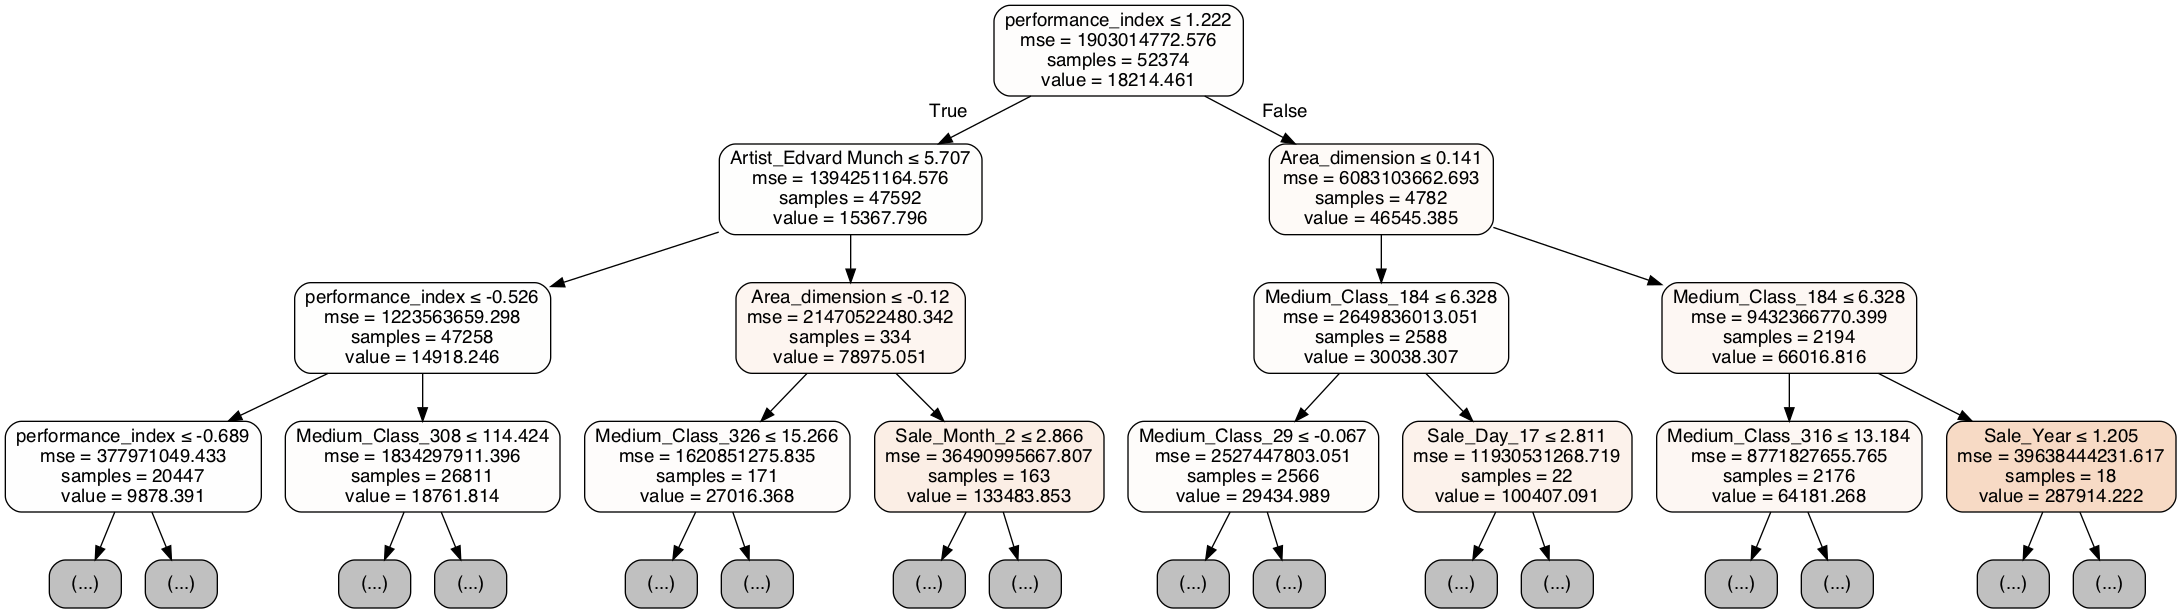

In [33]:
dot_data = StringIO()
export_graphviz(best_regressor,
                out_file=dot_data,
                max_depth=3,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=Xs_train.columns
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

#### Random Forest Regressor Model:
----
<a id="forest"></a>
- Random Forest is an ensemble technique.
- It involves training each decision tree on a different data sample where sampling is done with replacement.
- Multiple decision trees are combined in determining the final output 
- It changes the algorithm for the way that the sub-trees are learned so that the resulting predictions from all of the subtrees have less correlation.

In [34]:
forest = RandomForestRegressor(n_estimators=300, criterion='mse', max_depth=None, max_features='auto', bootstrap=True, random_state=1)
forest_params = {'max_depth': range(3,11)}

forest_gs = GridSearchCV(forest, forest_params, verbose=1, cv=5, n_jobs=-1)

In [35]:
forest_gs.fit(Xs_train, y_train)
best_forest = forest_gs.best_estimator_
dump(best_forest, '100best_forest.joblib')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 22.3min finished


['100best_forest.joblib']

In [36]:
print('Best params: ', best_forest.get_params)
print('Best train score: ', forest_gs.best_score_)
print('Best test score: ', best_forest.score(Xs_test, y_test))
print('Cross validated score: ', cross_val_score(best_forest, Xs_train, y_train, cv=5).mean())

Best params:  <bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)>
Best train score:  0.040554218459059696
Best test score:  0.04916778237761865
Cross validated score:  0.0405541778323969


In [37]:
feature_importances = best_forest.feature_importances_
pd.DataFrame(list(zip(Xs_train.columns, best_forest.feature_importances_)), columns=[
             'Feature', 'Importance']).sort_values(by='Importance', ascending=False).head()

,Feature,Importance
1,Area_dimension,0.236884
3,performance_index,0.153325
0,Total_prints,0.063369
211,Medium_Class_184,0.027599
2,Sale_Year,0.026604


#### KNeighbours Regressor Model:
---
<a id="knn"></a>
- Knn uses ‘feature similarity’ to predict values of any new data points.
- A new point is assigned a value based on how closely it resembles the points in the data set. 
- There are various methods for calculating the distance between observations, The most common is Euclidian.

In [38]:
kn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto')
kn_params = {'n_neighbors': range(2,15),
             'weights': ['uniform','distance']
                }

In [39]:
kn_gs = GridSearchCV(kn, kn_params, verbose=1, cv=5, n_jobs=-1)

In [41]:
kn_gs.fit(Xs_train, y_train)
best_kn = kn_gs.best_estimator_
dump(best_kn, '100best_knregressor.joblib')
print('Best params: ', best_kn.get_params)
print('Best train score: ', kn_gs.best_score_)
print('Best test score: ', best_kn.score(Xs_test, y_test))
print('Cross validated score: ', cross_val_score(best_kn, Xs_train, y_train, cv=5).mean())

Fitting 5 folds for each of 26 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 64.8min
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed: 234.3min finished


Best params:  <bound method BaseEstimator.get_params of KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=14, p=2,
          weights='distance')>
Best train score:  -0.13895514475788573
Best test score:  0.10242029392341057
Cross validated score:  -0.13895578035572204


#### Bagging Regressor Model:
----
<a id="bag"></a>
- Bagging Regressor can be used to form an ensemble of regressors.
- An ensemble method is a technique that combines the predictions from multiple machine learning algorithms together to make more accurate predictions than any individual model.
- It can be used to reduce the variance for those algorithm that have high variance, such as a decision tree regressor or KNN regressor

In [44]:
bagging = BaggingRegressor(base_estimator=None, n_estimators=300, max_samples=1.0, max_features=1.0,random_state=1)
bagging_params = {'base_estimator': [DecisionTreeRegressor()], 
                'max_samples': np.linspace(0.1,1,5),
                'max_features':np.linspace(0.1,1,5)
                }
bagging_gs = GridSearchCV(bagging, bagging_params, verbose=1, cv=3, n_jobs=-1)

In [45]:
bagging_gs.fit(Xs_train, y_train)
best_bagging = bagging_gs.best_estimator_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 60.5min finished


['100best_bagging.joblib']

In [46]:
print('Best params: ', best_bagging.get_params)
print('Best train score: ', bagging_gs.best_score_)
print('Best test score: ', best_bagging.score(Xs_test, y_test))
print('Cross validated score: ', cross_val_score(best_bagging, Xs_train, y_train, cv=5).mean())

Best params:  <bound method BaseEstimator.get_params of BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.775,
         max_samples=0.325, n_estimators=300, n_jobs=None, oob_score=False,
         random_state=1, verbose=0, warm_start=False)>
Best train score:  0.08014206806880816
Best test score:  0.19458468382076533
Cross validated score:  0.07666303151713458


#### Decision Tree + Bagging Regressor gives the best cross validation, 0.07666 and test score, 0.19458!

In [48]:
bag_pred = best_bagging.predict(Xs_test)

In [68]:
bagtrain_pred = best_bagging.predict(Xs_train)

Text(0, 0.5, 'Predicted Sale Price')

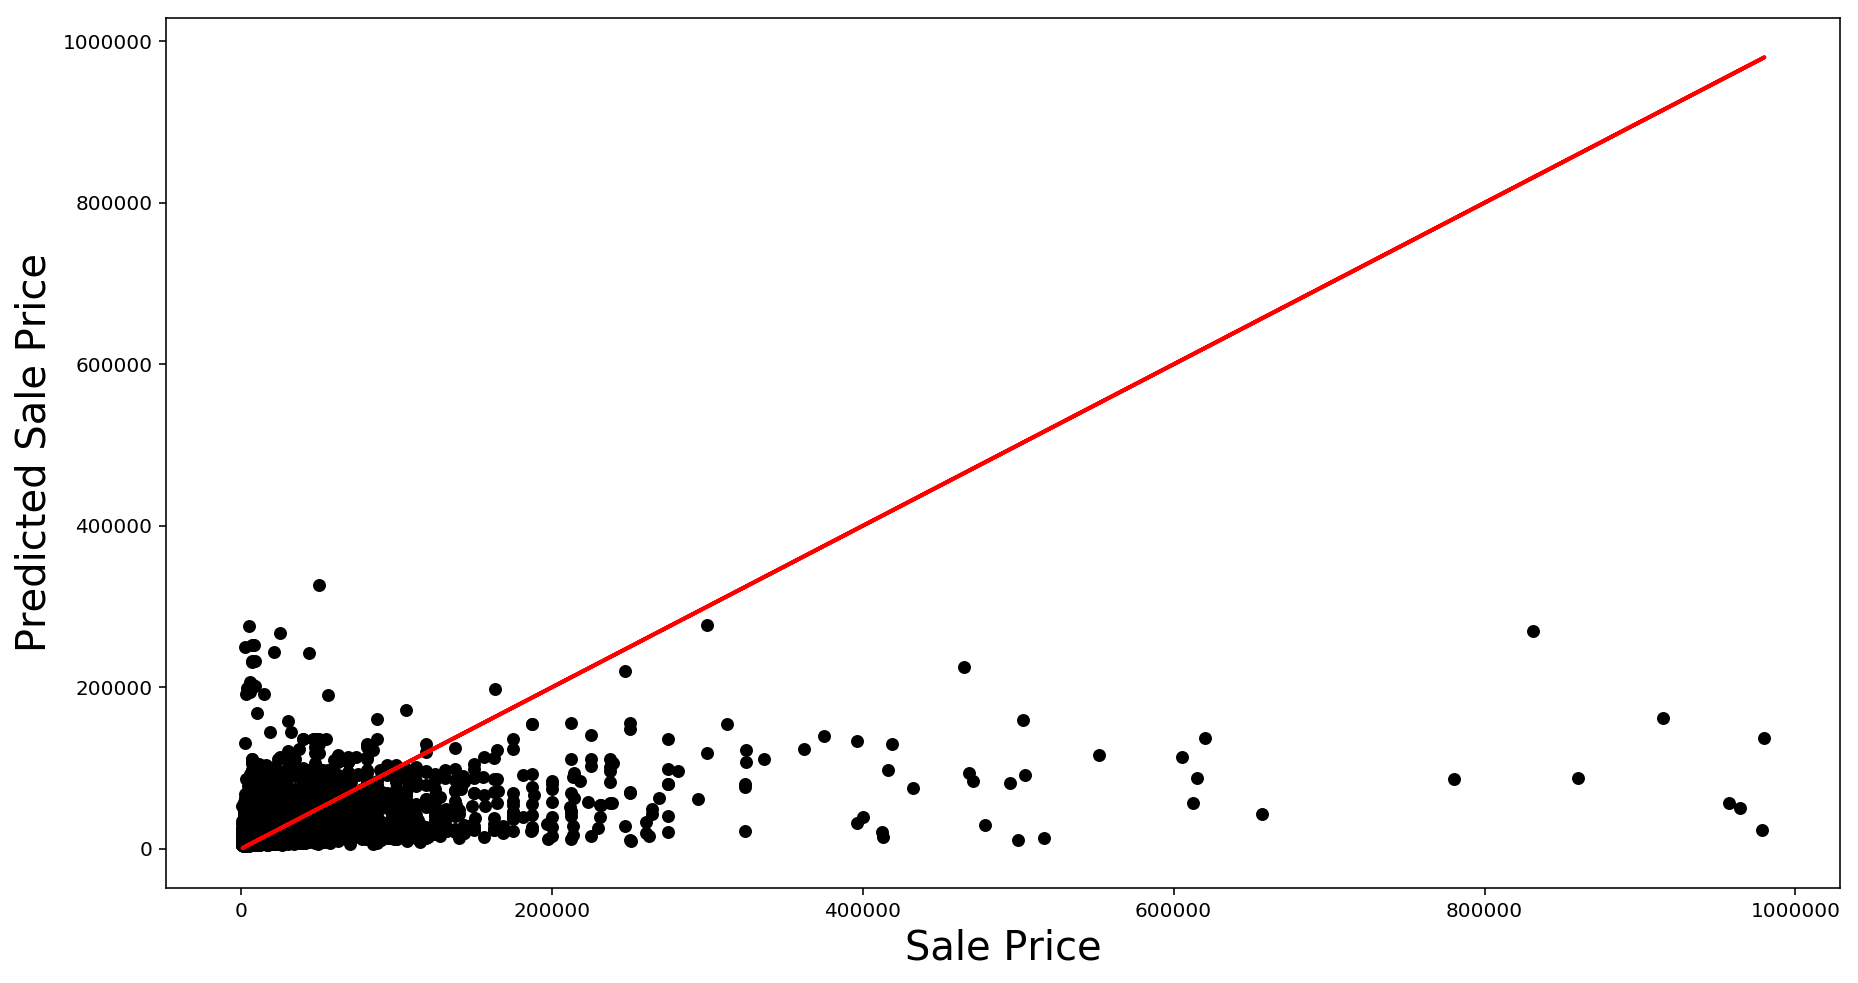

In [50]:
fig = plt.figure(figsize=(15, 8))
ax = fig.gca()

ax.scatter(x=y_test, y=bag_pred, c='k', s=30)
ax.plot(y_test, y_test, color='r', lw=2)
ax.set_xlabel('Sale Price',fontsize=20)
ax.set_ylabel('Predicted Sale Price',fontsize=20)

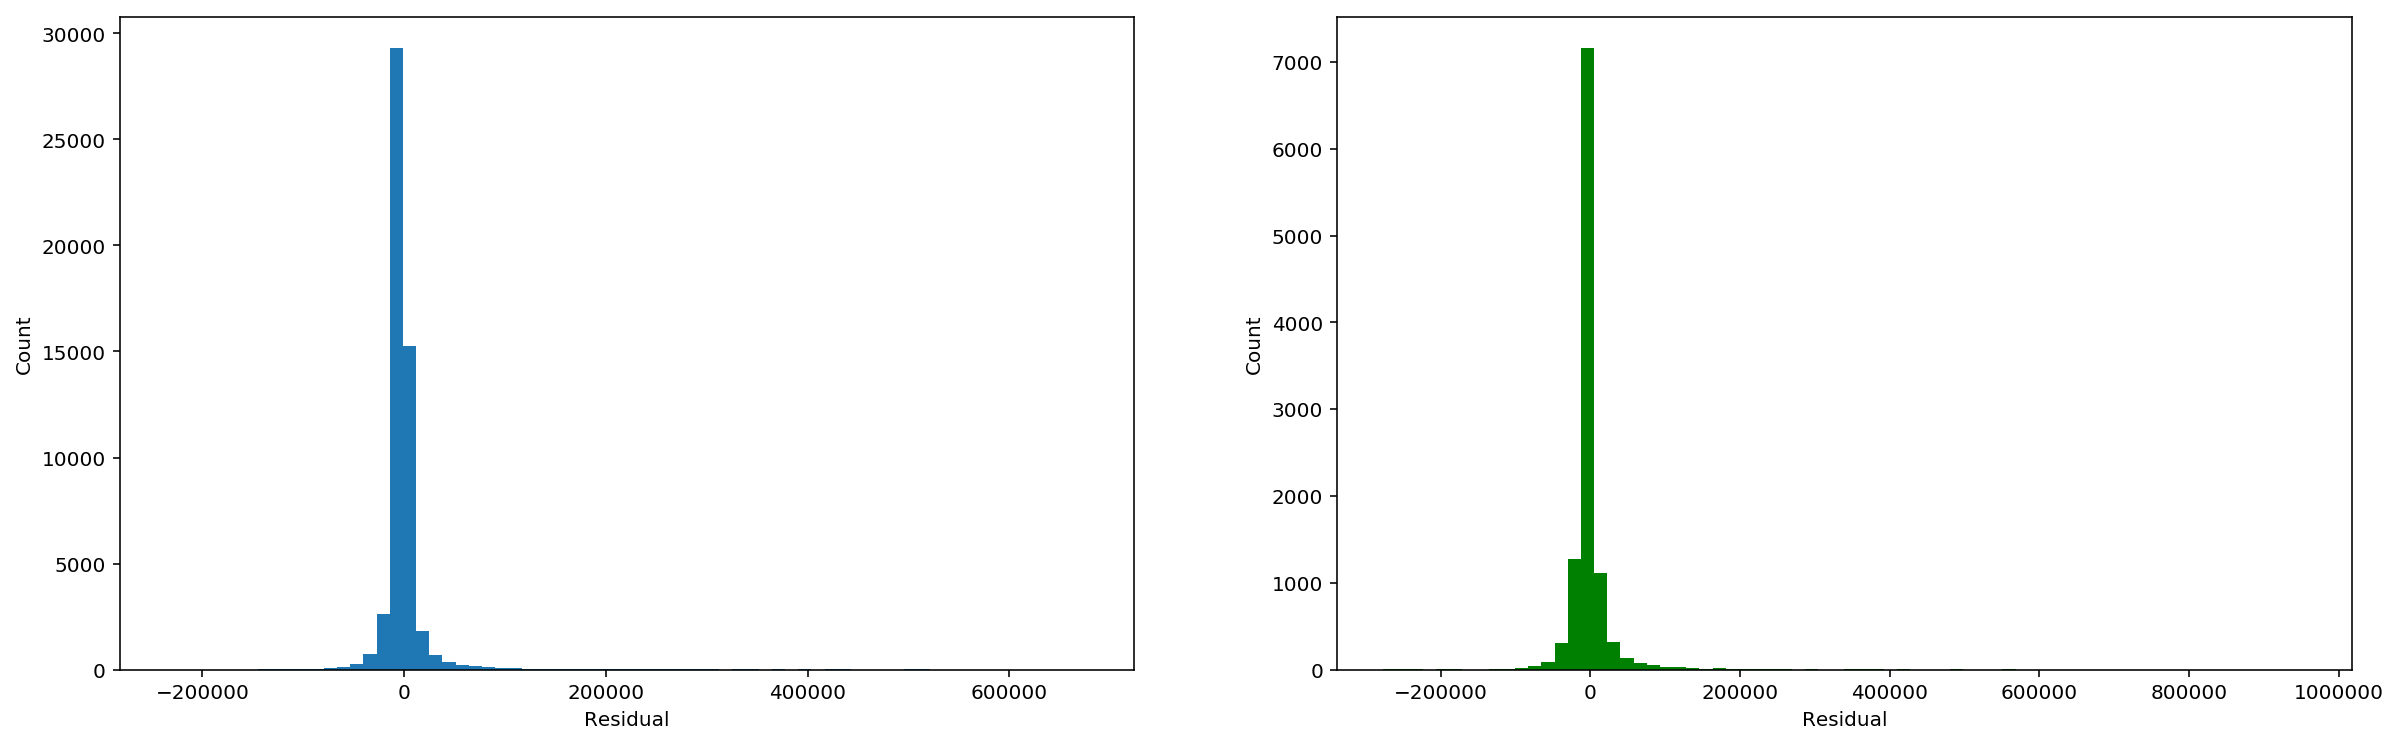

In [71]:
bagres_train = y_train - bagtrain_pred
bagres_test = y_test - bag_pred
fig, ax = plt.subplots(1,2, figsize=(20, 6))
ax[0].hist(bagres_train, bins= 70)
ax[0].set_xlabel('Residual')
ax[0].set_ylabel('Count')

ax[1].hist(bagres_test, bins= 70, color = 'g')
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Count')

plt.show()

#### Adaboost + Bagging:
<a id="ada"></a>

---

- Unfortunately this doesn't improve the score

In [20]:
base = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=300, max_features=0.775,
         max_samples=0.325, random_state=1, n_jobs=-1)

In [23]:
boost = AdaBoostRegressor(base_estimator=base,
                           n_estimators=300,
                           random_state=1)
boost.fit(Xs_train, y_train)

print(boost.score(Xs_train, y_train))
print(cross_val_score(boost, Xs_train, y_train, cv=5).mean())
#train score: 0.8086170784550664
#cross validation score: 0.06121290155071359

In [22]:
print(boost.score(Xs_test, y_test))

0.16477129751436814
